In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from collections import OrderedDict

import nept
import scalebar

from loading_data import get_data
from utils_maze import find_zones

In [2]:
output_filepath = 'E:/code/emi_shortcut/plots/intermediate'
pickle_filepath = 'E:/code/emi_shortcut/cache/pickled'

# output_filepath = 'C:/Users/Emily/code/emi_shortcut/plots/intermediate'
# pickle_filepath = 'C:/Users/Emily/code/emi_shortcut/cache/pickled'

In [3]:
import info.r066d1 as info

In [4]:
events, position, spikes, lfp, lfp_theta = get_data(info)
xedges, yedges = nept.get_xyedges(position)

zones = find_zones(info, remove_feeder=True, expand_by=8)

experiment_time = 'pauseB'
filename = '_decode-' + experiment_time + '.pkl'
decode_filename = info.session_id + filename
pickled_decoded = os.path.join(pickle_filepath, decode_filename)

with open(pickled_decoded, 'rb') as fileobj:
    decode = pickle.load(fileobj)

In [5]:
neurons_filename = info.session_id + '_neurons.pkl'
pickled_neurons = os.path.join(pickle_filepath, neurons_filename)
with open(pickled_neurons, 'rb') as fileobj:
    neurons = pickle.load(fileobj)

In [17]:
def plot_sequence(ordered_spikes, start_time, stop_time, max_loc, 
                  ms_fraction=132, lfp=None, position=None, savepath=None):
    import matplotlib
    import seaborn as sns
    import math
    
    sns.set_style("white")
    sns.set_style("ticks")
    
    matplotlib.rc('xtick', labelsize=16) 
    matplotlib.rc('ytick', labelsize=16) 

    rows = len(ordered_spikes)
    add_rows = int(rows / 8)

    ms = ms_fraction / rows
    mew = 0.7
    spike_loc = 1

    fig = plt.figure(figsize=(4, 6))
    ax1 = plt.subplot2grid((rows+add_rows, 1), (0, 0), rowspan=rows)

    for idx, neuron_spikes in enumerate(ordered_spikes):
        ax1.plot(neuron_spikes.time, np.ones(len(neuron_spikes.time))+(idx*spike_loc), '|',
                 color='k', ms=ms, mew=mew)
    ax1.set_xticks([])
    ax1.set_xlim([start_time, stop_time])
    ax1.set_ylim([0., math.ceil(len(ordered_spikes)*spike_loc+1)])

    if lfp is not None:
        z_thresh = 3.0
        merge_thresh = 0.02
        min_length = 0.05
        swrs = nept.detect_swr_hilbert(lfp, fs=info.fs, z_thresh=z_thresh,
                                       merge_thresh=merge_thresh, min_length=min_length)
        swr_lfp = lfp.time_slice(swrs.starts, swrs.stops)

        ax2 = plt.subplot2grid((rows+add_rows, 1), (rows, 0), rowspan=add_rows, sharex=ax1)
        start_idx = nept.find_nearest_idx(lfp.time, start_time)
        stop_idx = nept.find_nearest_idx(lfp.time, stop_time)
        ax2.plot(lfp.time[start_idx:stop_idx], lfp.data[start_idx:stop_idx], '#3288bd', lw=0.3)
        ax2.plot(swr_lfp.time, swr_lfp.data, 'r', lw=0.3)
        ax2.set_xticks([])
        ax2.set_xlim([start_time, stop_time])
        ax2.set_yticks([])

        scalebar.add_scalebar(ax2, matchy=False, bbox_transform=fig.transFigure,
                              bbox_to_anchor=(0.9, 0.05), units='ms', fontsize=16)

    elif position is not None:
        ax2 = plt.subplot2grid((rows+add_rows, 1), (rows, 0), rowspan=add_rows, sharex=ax1)
        start_idx = nept.find_nearest_idx(position.time, start_time)
        stop_idx = nept.find_nearest_idx(position.time, stop_time)
        ax2.plot(position.time[start_idx:stop_idx], position.x[start_idx:stop_idx], '#9970ab', lw=1)
        ax2.plot(position.time[start_idx:stop_idx], position.y[start_idx:stop_idx], '#5aae61', lw=1)
        ax2.set_xticks([])
        ax2.set_xlim([start_time, stop_time])
        ax2.set_yticks([])

        scalebar.add_scalebar(ax2, matchy=False, bbox_transform=fig.transFigure,
                              bbox_to_anchor=(0.9, 0.05), units='s')

    else:
        scalebar.add_scalebar(ax1, matchy=False, bbox_transform=fig.transFigure,
                              bbox_to_anchor=(0.9, 0.08), units='s')

    sns.despine(bottom=True)
    plt.tight_layout(h_pad=0.003)

    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight', transparent=True)
        plt.close()
    else:
        plt.show()

0


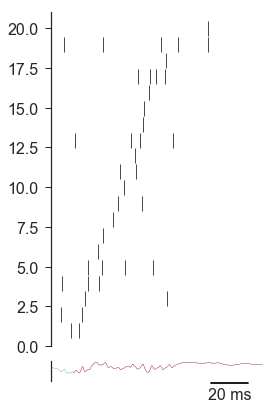

1


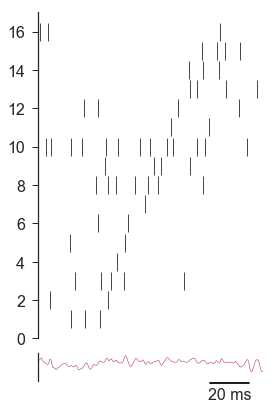

2


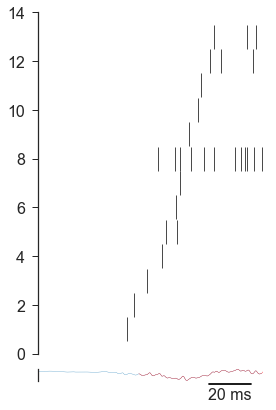

3


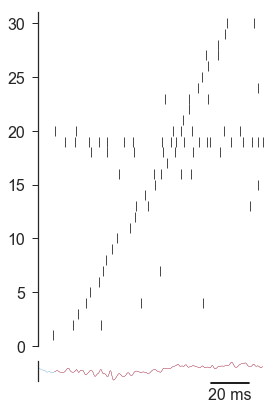

4


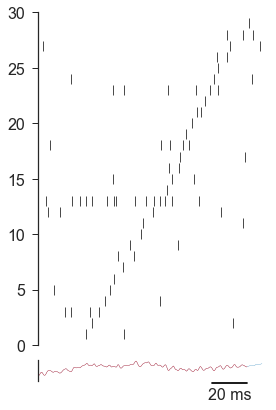

5


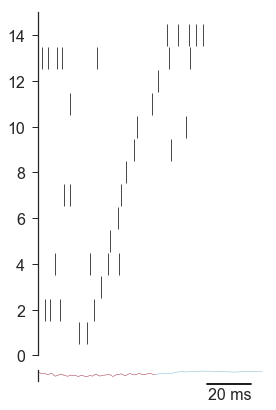

6


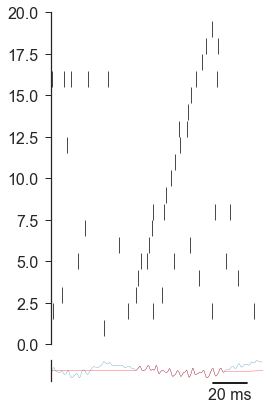

7


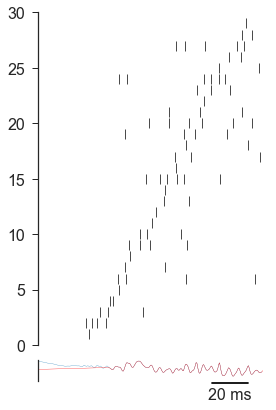

8


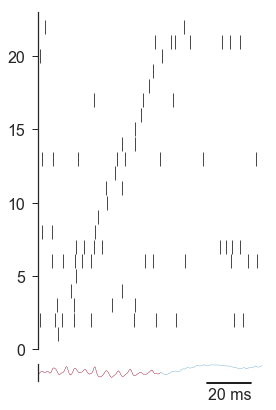

9


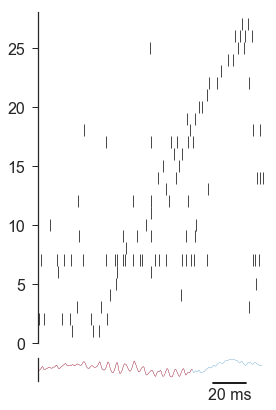

10


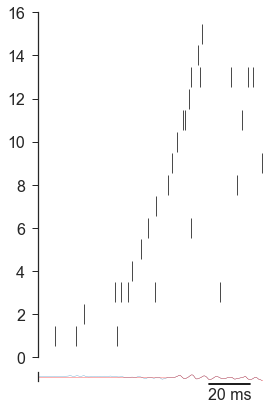

11


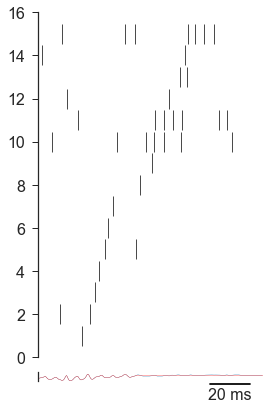

12


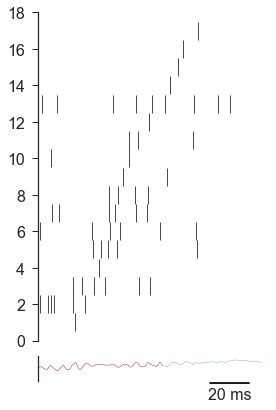

13


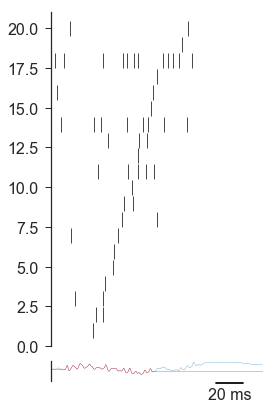

14


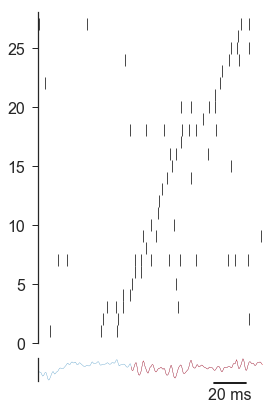

15


ValueError: need at least one array to concatenate

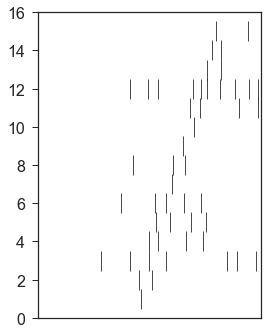

In [18]:
for idx in range(len(decode['epochs'].starts)):
    print(idx)
    start = decode['epochs'].starts[idx]
    stop = decode['epochs'].stops[idx]
    
    sliced_lfp = lfp.time_slice(start-10, stop+10)

    decoded_spikes = neurons.time_slice(start, stop)
    decoded_spikes = decoded_spikes.spikes
    position_sliced = position.time_slice(start, stop)
    
    dt = 0.0025
    counts = nept.bin_spikes(decoded_spikes, position_sliced, window_size=dt, window_advance=dt,
                             gaussian_std=0.005, normalized=True)
    
    peak_location = OrderedDict()

    for idx in range(np.shape(counts.data)[1]):
        if np.max(counts.data[:, idx]) > 0:
            peak_location[start+(np.argmax(counts.data[:, idx])*dt)] = decoded_spikes[idx]
            
    sort_neurons = OrderedDict()
    sorted_max = np.sort(list(peak_location.keys()))
    for val in sorted_max:
        sort_neurons[val] = peak_location[val]

    ordered = []
    for spike in sort_neurons.values():
        ordered.append(spike)

    plot_sequence(ordered,
                  start, 
                  stop,
                  max_loc = sorted_max,
                  ms_fraction=300,
                  lfp=sliced_lfp,
                  position=None)